# GBDT
梯度提升树（Gradient Boosting Decision Tree，GBDT）是提升法中的代表性算法，它即是当代强力的XGBoost、LGBM等算法的基石，也是工业界应用最多、在实际场景中表现最稳定的机器学习算法之一。在最初被提出来时，GBDT被写作梯度提升机器（Gradient Boosting Machine，GBM），它融合了Bagging与Boosting的思想、扬长避短，可以接受各类弱评估器作为输入，在后来弱评估器基本被定义为决策树后，才慢慢改名叫做梯度提升树。


- **GBDT最重要的思想:拟合残差**

> GBDT依然自适应调整弱评估器的构建，但却不像AdaBoost一样通过调整数据分布来**间接**影响后续弱评估器。相对的，GBDT通过修改后续弱评估器的拟合目标来直接影响后续弱评估器的结构。<br><br>
> 具体地来说，在AdaBoost当中，每次建立弱评估器之前需要修改样本权重，且用于建立弱评估器的是样本$X$以及对应的$y$，在GBDT当中，我们不修改样本权重，但每次用于建立弱评估器的是样本$X$以及当下集成输出$H(x_i)$与真实标签$y$的差异（$y - H(x_i)$）。这个差异在数学上被称之为残差（Residual），因此**GBDT不修改样本权重，而是通过拟合残差来影响后续弱评估器结构**。<br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold

### 首先我们不用gbdt自带库来运算,我们来理解它的算法流程

In [35]:
np.random.seed(42)
X = np.random.rand(500,2) - 0.5
y = 3*X[:,0]**2 +X[:,1]**3 +0.05*np.random.randn(500)

In [36]:
min(X[:,0]),max(X[:,0]),min(X[:,1]),max(X[:,1])#区间(-0.5,0.5)

(-0.4949384161537813,
 0.4966368370739054,
 -0.49536797699539714,
 0.4997176732861306)

In [37]:
from sklearn.tree import DecisionTreeRegressor

In [38]:
tree_reg1 = DecisionTreeRegressor(max_depth = 3)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=3)

In [40]:
y2 = y - tree_reg1.predict(X)####################真实值减去预测值就是残差值,用得到的残差值继续预测
tree_reg2 = DecisionTreeRegressor(max_depth = 3)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=3)

In [41]:
y3 = y2 - tree_reg2.predict(X)####################真实的残差值减去预测值就是残差值的残差值,用得到的残差值继续预测
tree_reg3 = DecisionTreeRegressor(max_depth = 3)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=3)

### 上面我们通过预测y,预测y的残差,再预测y的残差的残差,得到的三个预测结果加起来就是最终的预测结果

In [42]:
X_new = np.array([[0.4,0.6]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred

array([0.47718447])

In [55]:
def plot_predictions(models, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    arr1 = np.linspace(-0.5, 0.5, 500).reshape(500, 1)
    arr2 = np.linspace(-0.5, 0.5, 500).reshape(500, 1)
    x1 = np.concatenate((arr1, arr2), axis=1)
    
    y_pred = sum(model.predict(x1) for model in models)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1[:,0], y_pred, style, linewidth=2, label=label)
    # if label or data_label:
    plt.legend(loc="upper center", fontsize=10)
    plt.axis(axes)

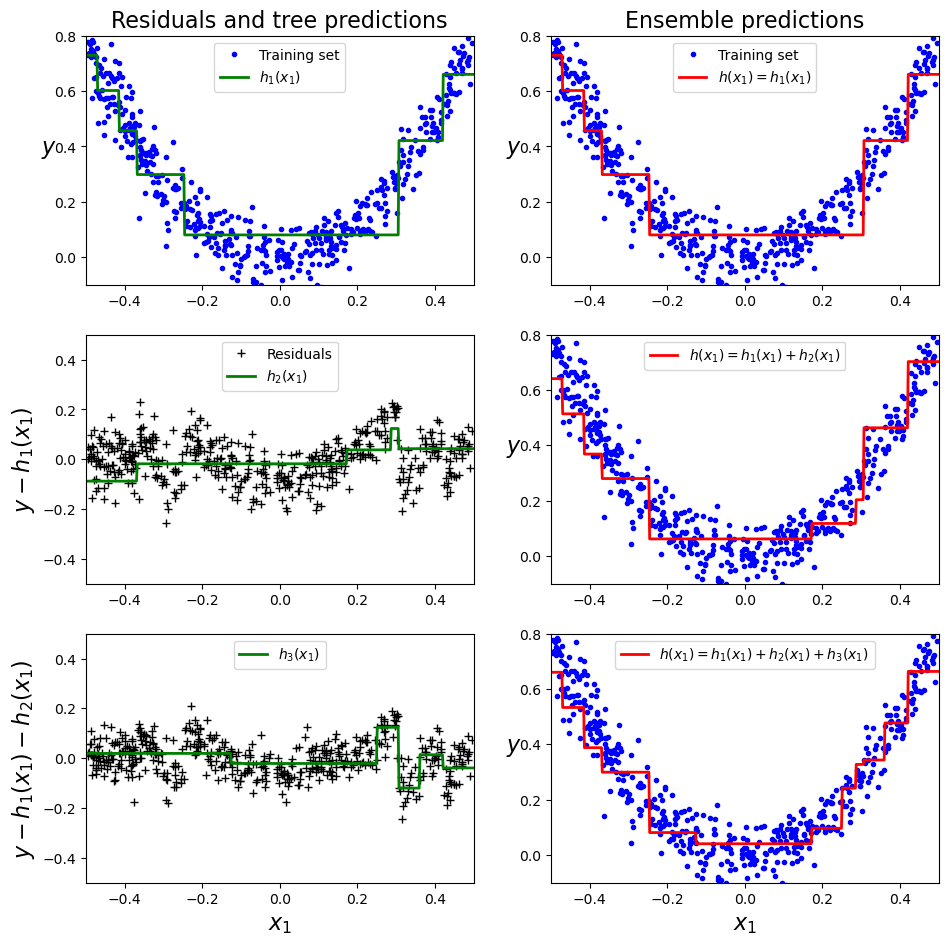

In [56]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

### 以上就是GBDT的基本流程

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

In [60]:
#探讨学习率和树个数的影响
gbrt = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 3,
                          learning_rate = 1.0,
                          random_state = 41
)
gbrt_slow_1 = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 3,
                          learning_rate = 0.1,
                          random_state = 41
)
gbrt_slow_2 = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 200,
                          learning_rate = 0.1,
                          random_state = 41
)

gbrt.fit(X,y)
gbrt_slow_1.fit(X,y)
gbrt_slow_2.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=41)

Text(0.5, 1.0, 'learning_rate=0.1,n_estimators=3')

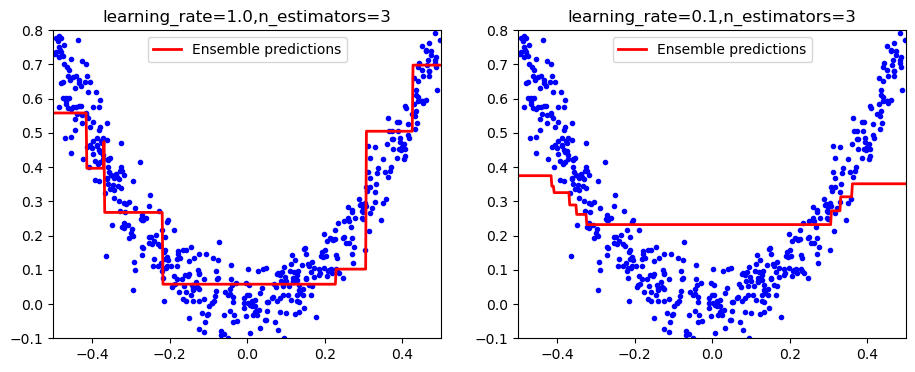

In [61]:
#不同学习率
plt.figure(figsize = (11,4))
plt.subplot(121)
plot_predictions([gbrt],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt.learning_rate,gbrt.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow_1],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate,gbrt_slow_1.n_estimators))

Text(0.5, 1.0, 'learning_rate=0.1,n_estimators=3')

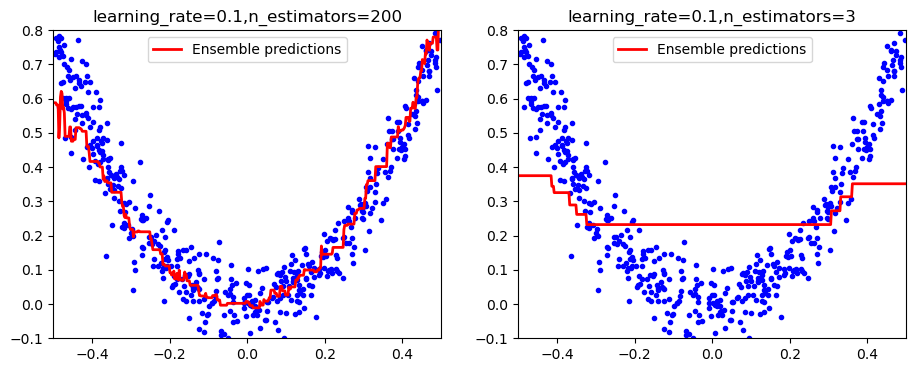

In [62]:
#不同树个数
plt.figure(figsize = (11,4))
plt.subplot(121)
plot_predictions([gbrt_slow_2],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_2.learning_rate,gbrt_slow_2.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow_1],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate,gbrt_slow_1.n_estimators))

### 交叉验证

In [64]:
#定义所需的交叉验证方式
cv = KFold(n_splits=10,shuffle=True,random_state=1412)

def RMSE(result,name):
    return abs(result[name].mean())

In [65]:
gbr = GBR(random_state=1412) #实例化
result_gbdt = cross_validate(gbr,X,y,cv=cv
                             ,scoring="neg_root_mean_squared_error" #负根均方误差
                             ,return_train_score=True
                             ,verbose=True
                             ,n_jobs=-1)

RMSE(result_gbdt,"train_score"),RMSE(result_gbdt,"test_score")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.4s finished


(0.03413545694162337, 0.05582864720843811)

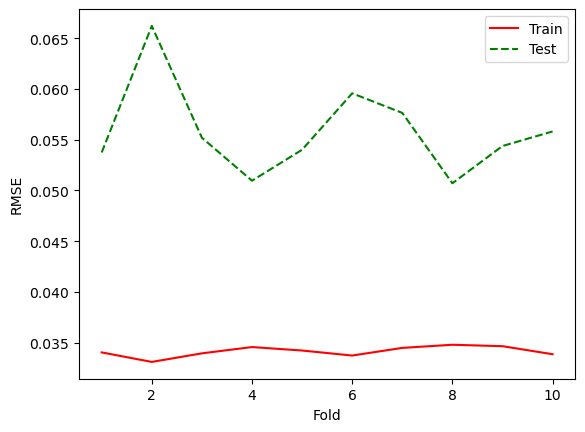

In [68]:
xaxis = range(1,11)
result = cross_validate(gbr,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
plt.plot(xaxis,abs(result["train_score"]), color='r', label = "Train")
plt.plot(xaxis,abs(result["test_score"]), color='g', linestyle="--",label = "Test")
plt.legend(loc=0)
plt.ylabel('RMSE')
plt.xlabel('Fold')
plt.show()

### 树并不一定越多越好,有可能会出现反弹现象,因此需要提前停止,在XGBoost,LGBM和Catboost中都有early stoping来提前停止训练,在GBDT需要自写策略

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=49)
gbrt = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 200,
                          random_state = 42
)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]    #获得200个误差
bst_n_estimators = np.argmin(errors)            #获得当errors最小时的X轴

gbrt_best = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = bst_n_estimators,
                          random_state = 42
)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=150, random_state=42)

In [90]:
np.argmin(errors)

150

In [76]:
min_error = np.min(errors)
min_error

0.0030486576375938017

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Best Model(150 trees)')

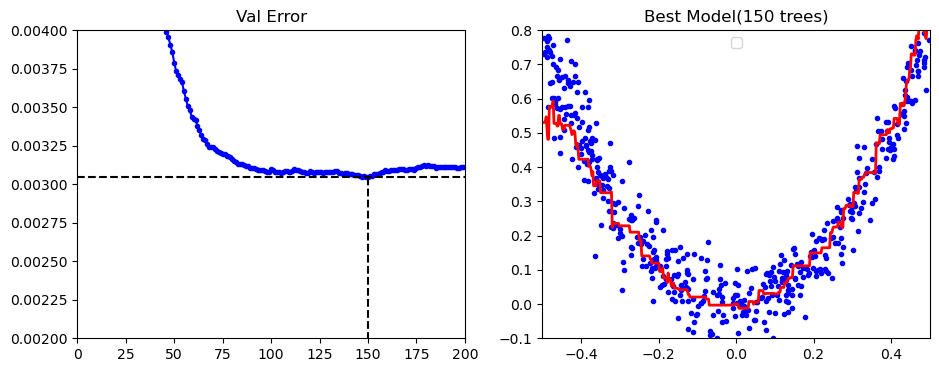

In [80]:
plt.figure(figsize = (11,4))
plt.subplot(121)
plt.plot(errors,'b.-')
plt.plot([bst_n_estimators,bst_n_estimators],[0,min_error],'k--')
plt.plot([0,200],[min_error,min_error],'k--')
plt.axis([0,200,0.002,0.004])
plt.title('Val Error')

plt.subplot(122)
plot_predictions([gbrt_best],X,y,axes=[-0.5,0.5,-0.1,0.8])
plt.title('Best Model(%d trees)'%bst_n_estimators)

从第一幅图可以明显看出误差出现回弹

In [84]:
gbrt = GradientBoostingRegressor(max_depth = 2,
                             random_state = 42,
                                 warm_start =True
)
error_going_up = 0
min_val_error = float('inf')

for n_estimators in range(1,200):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val,y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up +=1
        if error_going_up == 5:
            break
        

In [85]:
print (gbrt.n_estimators)

111
